In [1]:
import numpy as np
import pandas as pd
import spacy

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Dropout, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback, Callback

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 500)

In [3]:
EMBED_SIZE = 300
MAX_FEATURES = 200000
MAX_WORDS = 350
BATCH_SIZE = 256
EPOCHS = 100

In [4]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
embedding_path = "./glove.840B.300d.txt"

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

##It seems there are no missing comments
# train["comment_text"].fillna("unknown", inplace=True)
# test["comment_text"].fillna("unknown", inplace=True)

In [5]:
# Load spacy model
nlp = spacy.load('en_core_web_md', parser=False, entity=False)

In [6]:
##split the training data into training and validation ddatasets
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

raw_text_train = X_train["comment_text"]
raw_text_valid = X_valid["comment_text"]
raw_text_test = test["comment_text"]
X_test = test.copy()

In [7]:
##Covert the comments into sequence
tk = Tokenizer(num_words = MAX_FEATURES, lower = False)
tk.fit_on_texts(pd.concat([train["comment_text"], test["comment_text"]]))
X_train["comment_seq"] = tk.texts_to_sequences(raw_text_train)
X_valid["comment_seq"] = tk.texts_to_sequences(raw_text_valid)
X_test["comment_seq"] = tk.texts_to_sequences(raw_text_test)

c:\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(array([18203., 23903., 19906., 14656., 11604.,  9152.,  7036.,  5485.,
         4360.,  3566.,  2971.,  2520.,  2164.,  1734.,  1558.,  1341.,
         1311.,  1149.,  1007.,   757.,   747.,   682.,   564.,   517.,
          461.,   440.,   380.,   352.,   374.,   246.,   273.,   255.,
          191.,   177.,   143.,   148.,   149.,   138.,   129.,   119.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <a list of 40 Patch objects>)

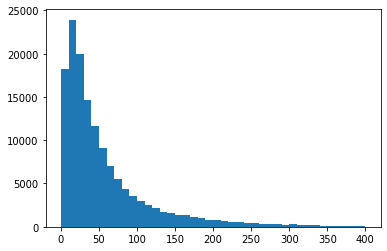

In [8]:
##Try to figure out the max number of words to keep based on histogram
totalNumWords = np.asarray([len(one_comment) for one_comment in X_train["comment_seq"].values])
plt.hist(totalNumWords,bins = np.arange(0,410,10))

In [9]:
#Oftentimes the words at the end also important
def get_seq_at_two_ends(seq):
    if len(seq)>MAX_WORDS:
        return seq[:MAX_WORDS-20] + seq[-20:]
    else:
        return seq

In [10]:
##Get the words at the beginning and and the end as the final comment feature
X_train["comment_seq"] = X_train["comment_seq"].apply(lambda seq: get_seq_at_two_ends(seq))
X_valid["comment_seq"] = X_valid["comment_seq"].apply(lambda seq: get_seq_at_two_ends(seq))
X_test["comment_seq"] = X_test["comment_seq"].apply(lambda seq: get_seq_at_two_ends(seq))

c:\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
###Make the input comments the same lengths
X_train = pad_sequences(X_train.comment_seq, maxlen = MAX_WORDS)
X_valid = pad_sequences(X_valid.comment_seq, maxlen = MAX_WORDS)
X_test = pad_sequences(X_test.comment_seq, maxlen = MAX_WORDS)

In [12]:
###Get the map of word to the index from the GloVe pretrained embedding matrix
embedding_index = {}
with open(embedding_path, encoding='utf-8') as em:
    for o in em:
        word_embed = o.strip().split(" ")
        embedding_index[word_embed[0]] = np.asarray(word_embed[1:], dtype='float16')

In [13]:
###Get the embedding matrix for our input features from GloVe embedding weights
MAX_FEATURES = min(MAX_FEATURES, len(tk.word_index))
embedding_matrix = np.zeros((MAX_FEATURES, EMBED_SIZE))
for word, i in tk.word_index.items():
    if i >= MAX_FEATURES: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [14]:
###Custom metric. In this case, auc under roc
def auc_acc(y_true, y_pred):
    # return tf.py_function(roc_auc_score, (y_true, y_pred), tf.float32)
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [15]:
####The first model structure 
# def build_model(lr = 1e-3, lr_d = 1e-6, units = 128, dr = 0.2):
#     model = Sequential()
    
#     model.add(Embedding(MAX_FEATURES, EMBED_SIZE, weights = [embedding_matrix], trainable = False, input_shape=(MAX_WORDS,)))
#     model.add(SpatialDropout1D(rate=dr))

#     model.add(Bidirectional(GRU(units, return_sequences = True)))
#     model.add(Bidirectional(GRU(units, return_sequences = True)))
#     model.add(GlobalMaxPool1D())
    
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(rate=dr))
#     model.add(Dense(6, activation = "sigmoid"))
    
#     model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = [auc_acc])
    
#     return model

In [16]:
####The second model structure
def build_model(lr = 1e-3, lr_d = 1e-6, units = 128, dr = 0.2):
    model = Sequential()
    
    model.add(Embedding(MAX_FEATURES, EMBED_SIZE, weights = [embedding_matrix], trainable = False, input_shape=(MAX_WORDS,)))
    model.add(SpatialDropout1D(rate=dr))

    model.add(Bidirectional(GRU(units, return_sequences = True, dropout=dr, recurrent_dropout=dr)))
    model.add(Bidirectional(GRU(units, return_sequences = True, dropout=dr, recurrent_dropout=dr)))
    model.add(Conv1D(units, kernel_size=3, padding='valid', activation=None))
    model.add(Dropout(rate=dr))
    model.add(GlobalMaxPool1D())
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=dr))
    model.add(Dense(6, activation = "sigmoid"))
    
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = [auc_acc])
    
    return model

In [17]:
####It will be ideal to use GridSearchCV and KerasClassifier to tune the hyper-parameters.
####But it takes long time to train the model. Therefore, no search is made.
model = build_model(lr = 1e-3, lr_d = 1e-6, units = 128, dr = 0.2)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 350, 300)          60000000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 350, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 350, 256)          329472    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 350, 256)          295680    
_________________________________________________________________
conv1d_1 (Conv1D)          

In [18]:
####The metrics I am looking at is both binary_crossentropy and auc. Therefore, define a custom callback
class saveModel(Callback):
    def __init__(self, patience=3, file_path="best_model.hdf5", verbose=0):
        super(Callback, self).__init__()
        self.patience = patience
        self.file_path = file_path
        self.verbose = verbose
        
    def on_train_begin(self, logs={}):
        self.best_auc = 0
        self.best_loss = 1
        self.halt = 0        

    def on_epoch_end(self, epoch, logs={}):
        if logs['val_auc_acc']>self.best_auc and logs['val_loss']<self.best_loss:
            if self.verbose > 0:
                print('   Epoch {} - Previous auc: {:.4f}, Previous loss: {:.4f}; New auc: {:.4f}, New loss: {:.4f}' \
                      .format(epoch+1, self.best_auc, self.best_loss, logs['val_auc_acc'], logs['val_loss']))
            self.best_auc = logs['val_auc_acc']
            self.best_loss = logs['val_loss']
            self.model.save(self.file_path)
        if logs['val_auc_acc']<self.best_auc or logs['val_loss']>self.best_loss:
            self.halt += 1
        else:
            self.halt = 0
        if self.halt > self.patience:
            if self.verbose > 0:
                print("   Epoch {}: early stopped. auc: {:.4f}, loss: {:.4f}".format(epoch+1, self.best_auc, self.best_loss))
            self.model.stop_training = True

model_callback = saveModel(patience=5, verbose=1)

history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, shuffle=True, epochs = EPOCHS, validation_data = (X_valid, Y_valid), 
                        verbose = 2, callbacks = [model_callback])

Instructions for updating:
Use tf.cast instead.
Train on 143613 samples, validate on 15958 samples
Epoch 1/100
 - 947s - loss: 0.0685 - auc_acc: 0.9047 - val_loss: 0.0492 - val_auc_acc: 0.9622
   Epoch 1 - Previous auc: 0.0000, Previous loss: 1.0000; New auc: 0.9622, New loss: 0.0492
Epoch 2/100
 - 949s - loss: 0.0484 - auc_acc: 0.9688 - val_loss: 0.0470 - val_auc_acc: 0.9727
   Epoch 2 - Previous auc: 0.9622, Previous loss: 0.0492; New auc: 0.9727, New loss: 0.0470
Epoch 3/100
 - 966s - loss: 0.0452 - auc_acc: 0.9751 - val_loss: 0.0429 - val_auc_acc: 0.9769
   Epoch 3 - Previous auc: 0.9727, Previous loss: 0.0470; New auc: 0.9769, New loss: 0.0429
Epoch 4/100
 - 966s - loss: 0.0432 - auc_acc: 0.9782 - val_loss: 0.0418 - val_auc_acc: 0.9793
   Epoch 4 - Previous auc: 0.9769, Previous loss: 0.0429; New auc: 0.9793, New loss: 0.0418
Epoch 5/100
 - 957s - loss: 0.0417 - auc_acc: 0.9802 - val_loss: 0.0411 - val_auc_acc: 0.9809
   Epoch 5 - Previous auc: 0.9793, Previous loss: 0.0418; New a

Text(0.5, 0, 'epoch')

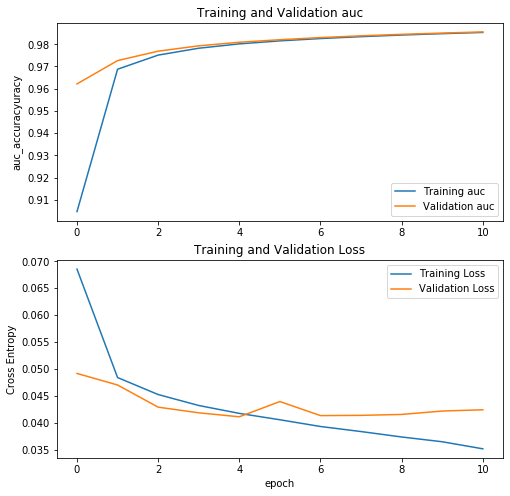

In [19]:
auc_accuracy = history.history['auc_acc']
val_auc_accuracy = history.history['val_auc_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(auc_accuracy, label='Training auc')
plt.plot(val_auc_accuracy, label='Validation auc')
plt.legend(loc='lower right')
plt.ylabel('auc_accuracyuracy')
plt.title('Training and Validation auc')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

In [20]:
file_path = "best_model.hdf5"
model = load_model(file_path, custom_objects={"auc_acc":auc_acc})

In [21]:
pred_train = model.predict(X_train, batch_size = 1024, verbose = 1)

143613/143613 [==============================] - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 59 - ETA: 58 - ETA: 57 - ETA: 56 - ETA: 55 - ETA: 54 - ETA: 53 - ETA: 52 - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - 

In [22]:
roc_auc_score(Y_train, pred_train)

0.991875406334081

In [23]:
pred_val = model.predict(X_valid, batch_size = 1024, verbose = 1)

15958/15958 [==============================] - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 14s 851us/step


In [24]:
roc_auc_score(Y_valid, pred_val)

0.9875985773980558

In [25]:
###Not all test samples are used in validation. Some test samples do not have labels, which are all -1
test_labels = pd.read_csv("./test_labels.csv")
valid_test_samples = test_labels[test_labels.iloc[:,1:].sum(axis=1)>=0].index
test_labels = test_labels.iloc[valid_test_samples,1:].values
X_test_labels = X_test[valid_test_samples,:].copy()

In [26]:
pred_test = model.predict(X_test_labels, batch_size = 1024, verbose = 1)

63978/63978 [==============================] - ETA: 52 - ETA: 51 - ETA: 50 - ETA: 49 - ETA: 49 - ETA: 48 - ETA: 47 - ETA: 46 - ETA: 45 - ETA: 45 - ETA: 44 - ETA: 43 - ETA: 42 - ETA: 41 - ETA: 40 - ETA: 39 - ETA: 38 - ETA: 37 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 34 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 25 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 54s 839us/step


In [27]:
roc_auc_score(test_labels, pred_test)

0.9821180093767454